In [1]:
import polars as pl
import time
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from func import timing

In [2]:
file_path = Path.home() / 'Downloads/2021_Yellow_Taxi_Trip_Data.csv'

In [3]:
def select_n_filter_columns(df):
    return (
        df
        .select(pl.col('VendorID', 'tpep_pickup_datetime', 'total_amount', 'tolls_amount', 'payment_type', 'tip_amount', 'fare_amount', 'PULocationID'))
        .filter(pl.col('total_amount') > 100)
    )

def some_groupby_agg(df):
    return (
        df
        .groupby('VendorID', 'payment_type', 'PULocationID')
        .agg(
            pl.col('tip_amount').mean().alias('avg_tip_amount')
        )
    )

def some_window_func(df):
    return (
        df
        .select(
            pl.col('VendorID'),
            pl.col('payment_type'),
            pl.col('tpep_pickup_datetime'),
            pl.col('PULocationID'),
            pl.col('tip_amount'),
            pl.col('fare_amount').mean().over('payment_type').alias('mean_fare_amt_per_payment_type'),
        )
        .with_columns(
            pl.col('mean_fare_amt_per_payment_type').rank('dense', descending=True).over('VendorID').alias('dense_rank')
        )
    )

def join_on_a_few_column(df):
    unique_vendor_id_df = df.select('VendorID', 'payment_type', 'PULocationID').unique()
    return (
        df
        .join(unique_vendor_id_df, on=['VendorID', 'payment_type', 'PULocationID'], how='left')
    )

@timing
def write_to_csv(df):
    output_file_name = 'output.csv'
    if type(df) == pl.LazyFrame:
        df.collect().write_csv(output_file_name)
        return
    
    return df.write_csv(output_file_name)

def test_performance(func_to_test):
    """
    performance test of one function - lazyframe vs dataframe
    """

    func_name = func_to_test.__name__

    def exec_func_lazyframe():
        """
        when write_to_csv func, don't collect()
        """
        if func_name == 'write_to_csv':
            return (
                pl.scan_csv(file_path)
                .pipe(func_to_test)
            )
        return (
                pl.scan_csv(file_path)
                .pipe(func_to_test)
                .collect()
            )

    ##### lazyframe #####
    start = time.time()
    exec_func_lazyframe()
    end = time.time()
    time_in_s = round(end - start, 2)
    print(func_to_test.__name__)
    print(f'-> LazyFrame took {time_in_s} seconds')
    result_lazy = [time_in_s, func_name, 'LazyFrame']

    ##### dataframe #####
    start = time.time()
    df = (
        pl.read_csv(file_path)
        .pipe(func_to_test)
    )
    end = time.time()
    time_in_s = round(end - start, 2)
    print(f'-> DataFrame took {time_in_s} seconds')
    result_dataframe = [time_in_s, func_name, 'DataFrame']

    return result_lazy, result_dataframe

def test_performance_all():
    """
    test performance for all functions used at once
    """
    ##### lazyframe #####
    start = time.time()
    lazy_df = (
        pl.scan_csv(file_path)
        .pipe(select_n_filter_columns)
        .pipe(some_window_func)
        .pipe(some_groupby_agg)
        .pipe(join_on_a_few_column)
        .pipe(write_to_csv)
    )
    end = time.time()
    time_in_s = round(end - start, 2)
    print(f'-> LazyFrame took {time_in_s} seconds')
    result_lazy = [time_in_s, 'All funcs at once', 'LazyFrame']

    ##### dataframe #####
    start = time.time()
    df = (
        pl.read_csv(file_path)
        .pipe(select_n_filter_columns)
        .pipe(some_window_func)
        .pipe(some_groupby_agg)
        .pipe(join_on_a_few_column)
        .pipe(write_to_csv)
    )
    end = time.time()
    time_in_s = round(end - start, 2)
    print(f'-> DataFrame took {time_in_s} seconds')
    result_dataframe = [time_in_s, 'All funcs at once', 'DataFrame']

    return result_lazy, result_dataframe

def visualize_result(data):
    """
    visualize retuslt and save it as png
    """
    sns.set_style(style=None)

    df = pl.DataFrame(data, schema=['time in seconds', 'func', 'type'])

    plt.figure(figsize=(20, 6))
    ax = sns.barplot(x=list(df['func']), y=list(df['time in seconds']), hue=list(df['type']), errorbar=None, palette=['#000000', '#d3d3d3'])
    # adding labels
    for container in ax.containers:
        ax.bar_label(container)
    ax.set(xlabel='', ylabel='Time in Seconds')
    plt.title('LazyFrame vs DataFrame - Polars')
    plt.show()

    # export to png
    fig = ax.get_figure()
    fig.savefig('LazyFrame vs DataFrame - Polars.png')

1. Testing performance - a function at a time
select_n_filter_columns
-> LazyFrame took 2.25 seconds
-> DataFrame took 6.36 seconds
some_window_func
-> LazyFrame took 2.92 seconds
-> DataFrame took 7.28 seconds
some_groupby_agg
-> LazyFrame took 1.4 seconds
-> DataFrame took 6.3 seconds
join_on_a_few_column
-> LazyFrame took 8.15 seconds
-> DataFrame took 7.22 seconds
write_to_csv took: 14.52 sec
write_to_csv
-> LazyFrame took 14.53 seconds
write_to_csv took: 7.29 sec
-> DataFrame took 14.78 seconds

2. Testing performance - all functions at once
write_to_csv took: 2.66 sec
-> LazyFrame took 2.66 seconds
write_to_csv took: 0.00 sec
-> DataFrame took 6.44 seconds


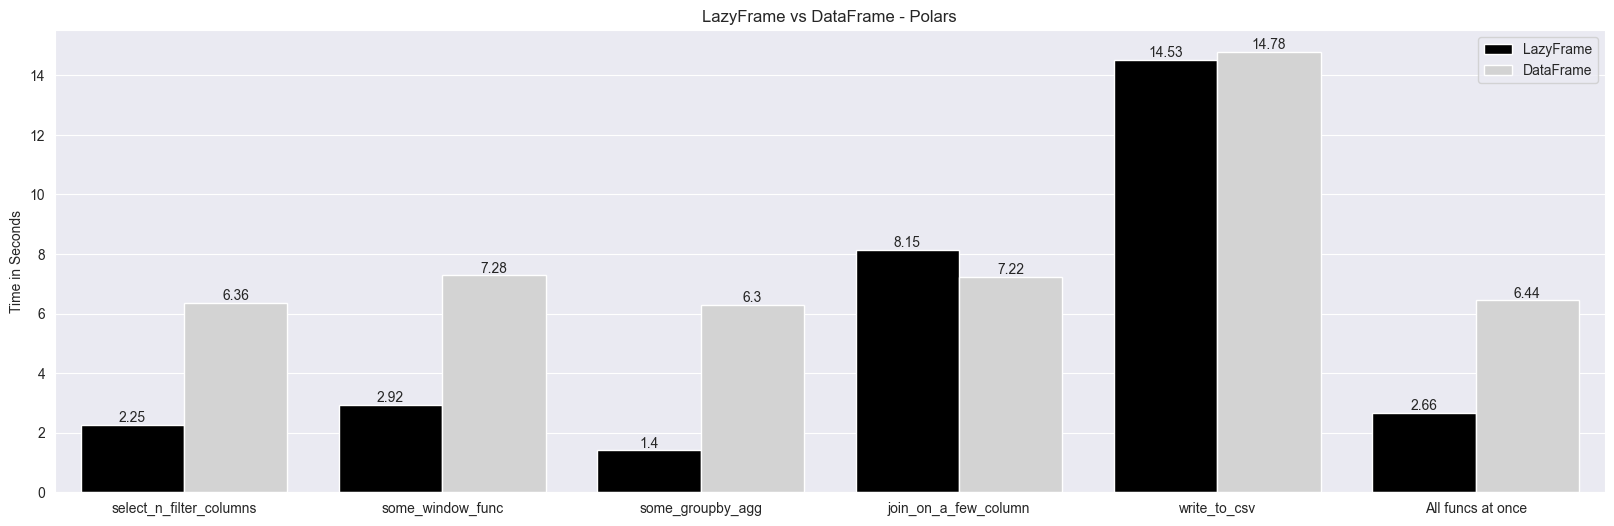

In [4]:
data = []
functions = [
    select_n_filter_columns, 
    some_window_func, 
    some_groupby_agg, 
    join_on_a_few_column,
    write_to_csv
    ]

print('1. Testing performance - a function at a time')
for func in functions:
    result_lazy, result_dataframe = test_performance(func)
    data.append(result_lazy)
    data.append(result_dataframe)

print('\n2. Testing performance - all functions at once')
result_lazy, result_dataframe = test_performance_all()
data.append(result_lazy)
data.append(result_dataframe)

visualize_result(data)

In [6]:
lf = pl.LazyFrame(
    {
        "a": ["a", "b", "a", "b", "b", "c"],
        "b": [1, 2, 3, 4, 5, 6],
        "c": [6, 5, 4, 3, 2, 1],
    }
)
print(lf.groupby("a", maintain_order=True).agg(pl.all().sum()).sort(
    "a"
).explain())

SORT BY [col("a")]
  AGGREGATE
  	[col("b").sum(), col("c").sum()] BY [col("a")] FROM
    DF ["a", "b", "c"]; PROJECT 3/3 COLUMNS; SELECTION: "None"


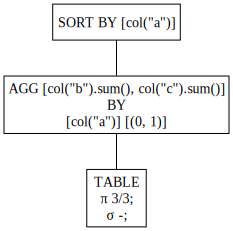

In [9]:
lf.groupby("a", maintain_order=True).agg(pl.all().sum()).sort(
    "a"
).show_graph()